In [1]:
import retentioneering

In [2]:
# load sample data
from retentioneering import datasets
data = datasets.load_simple_ab_test()

data.head()

,client_id,event,timestamp,user_backet,transaction_value,transaction_ID
0,219483890,catalog,2019-11-01 17:59:13.273932,test,NaN,None
1,219483890,product,2019-11-01 17:59:28.459271,test,NaN,None
2,219483890,cart,2019-11-01 17:59:29.502214,test,NaN,None
3,219483890,catalog,2019-11-01 17:59:32.557029,test,NaN,None
4,964964743,catalog,2019-11-01 21:38:19.283663,test,NaN,None


In [3]:
retentioneering.config.update({
    'event_col':'event',
    'event_time_col':'timestamp',
    'index_col': 'client_id'
})

In [4]:
(data
 .drop_duplicates(subset=['client_id'])['user_backet']
 .value_counts())

not_in_test    2624
control         573
test            554
Name: user_backet, dtype: int64

In [5]:
test = data[data['user_backet']=='test']['client_id'].unique()
control = data[data['user_backet']=='control']['client_id'].unique()

test (mean ± SD): 0.227 ± 0.419, n = 554
control (mean ± SD): 0.148 ± 0.355, n = 573
'test' is greater than 'control' with P-value: 0.00034


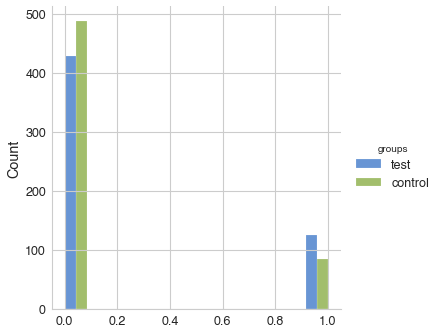

In [6]:
convertion = lambda x: int(['payment_done'] in x['event'].unique())

data.rete.compare(groups=(test, control),
                  function=convertion,
                  test='mannwhitneyu',
                  group_names=('test','control'))

test (mean ± SD): 736.026 ± 149.001, n = 126
control (mean ± SD): 732.980 ± 139.960, n = 85
'test' is less than 'control' with P-value: 0.55199


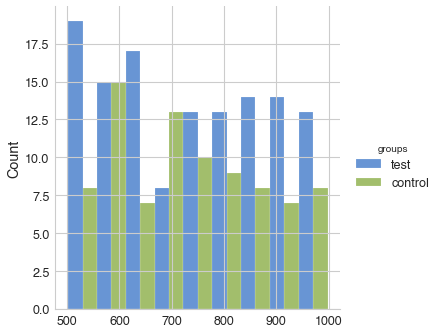

In [7]:
average_check = lambda x: x['transaction_value'].mean()


data.rete.compare(groups=(test, control),
                  function=average_check,
                  test='ks_2samp',
                  group_names=('test','control'))

In [8]:
import pandas as pd
import random

all_ids = data['transaction_ID'].dropna().unique()
status = pd.DataFrame({'transaction_ID': all_ids, 
                       'confirmed': [random.random() > 0.2 
                                     for _ in all_ids]})

status.head()

,transaction_ID,confirmed
0,7121884,True
1,9641982,True
2,9826287,True
3,9647603,True
4,8125650,True


In [9]:
def confirmed_purch(x):
    
    # get list of transactions for user x
    trans_list = x['transaction_ID'].unique()
    
    # get all status records for transactions from user x
    trans_status = status[status['transaction_ID'].isin(trans_list)]
    
    # True / False if user has conf transactions
    has_conf_trans = trans_status['confirmed'].sum() > 0
    
    # convert bool to int:
    return int(has_conf_trans)


test (mean ± SD): 0.179 ± 0.383, n = 554
control (mean ± SD): 0.119 ± 0.323, n = 573
'test' is greater than 'control' with P-value: 0.00230


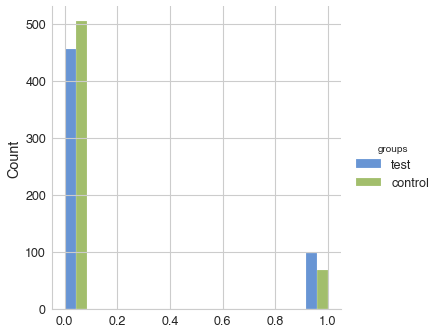

In [10]:
data.rete.compare(groups=(test, control),
                  function=confirmed_purch,
                  test='mannwhitneyu',
                  group_names=('test','control'))